## User based Approach User per Graph modeling

In [2]:
!pip install torch torch_geometric networkx pandas numpy scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
import pandas as pd
import networkx as nx


In [11]:
df_course = pd.read_csv('/content/top_02percent_most_sessions.csv')

In [7]:
df_course.columns

Index(['username', 'enroll_id', 'session_id', 'course_id', 'action', 'time',
       'category', 'session_duration', 'session_gap', 'action_count',
       'action_frequency'],
      dtype='object')

In [8]:
df_course.head(3)

,username,enroll_id,session_id,course_id,action,time,category,session_duration,session_gap,action_count,action_frequency
0,1921,2331,0e914c1dff2f62c1a9e2550aa4cbc0e4,course-v1:TsinghuaX+70800232X+2015_T2,click_about,2015-10-21T12:05:44.000Z,art,9139.0,682715.0,15.0,0.001641
1,1921,2331,0e914c1dff2f62c1a9e2550aa4cbc0e4,course-v1:TsinghuaX+70800232X+2015_T2,click_about,2015-10-21T12:05:47.000Z,art,9139.0,682715.0,15.0,0.001641
2,1921,2331,0e914c1dff2f62c1a9e2550aa4cbc0e4,course-v1:TsinghuaX+70800232X+2015_T2,click_about,2015-10-21T13:31:42.000Z,art,9139.0,682715.0,15.0,0.001641


In [7]:
df.isnull().sum()

,0
username,0
enroll_id,0
session_id,0
course_id,0
action,0
time,0
category,0
session_duration,0
session_gap,0
action_count,0


In [9]:
for user in top_users:
    user_data = df[df['username'] == user]
    print(f"User {user}: {len(user_data)} rows")


User 1088784: 13999 rows
User 1095269: 12129 rows
User 1087888: 11120 rows
User 658649: 10929 rows
User 4443453: 10004 rows
User 611546: 8911 rows
User 1066027: 8745 rows
User 1177246: 8397 rows
User 1080845: 7993 rows
User 669890: 7703 rows
User 356347: 7664 rows
User 310599: 7653 rows
User 258011: 7498 rows
User 1068955: 6797 rows
User 67512: 6771 rows
User 186593: 6499 rows
User 3579993: 6377 rows
User 455666: 6246 rows
User 1087639: 5786 rows
User 174043: 5580 rows


In [11]:
import torch
import networkx as nx
from torch_geometric.utils import from_networkx

def build_user_graph(df, username):
    user_data = df[df['username'] == username]

    if len(user_data) == 0:
        print(f"Skipping user {username} (no data)")
        return None

    G = nx.DiGraph()  # Directed graph

    # Ensure all attributes exist (prevent missing values)
    default_values = {
        'action': 0, 'course': 0, 'category': 0,
        'session_duration': 0.0, 'session_gap': 0.0,
        'action_count': 0.0, 'action_frequency': 0.0
    }

    # Add nodes
    for _, row in user_data.iterrows():
        node_id = row['session_id']
        G.add_node(node_id,
                   action=int(row.get('action', default_values['action'])),
                   course=int(row.get('course_id', default_values['course'])),
                   category=int(row.get('category', default_values['category'])),
                   session_duration=float(row.get('session_duration', default_values['session_duration'])),
                   session_gap=float(row.get('session_gap', default_values['session_gap'])),
                   action_count=float(row.get('action_count', default_values['action_count'])),
                   action_frequency=float(row.get('action_frequency', default_values['action_frequency'])))

    # Add edges (sequence of actions within a session)
    sorted_sessions = user_data.sort_values(by='time')
    prev_session = None
    for _, row in sorted_sessions.iterrows():
        if prev_session:
            G.add_edge(prev_session, row['session_id'])  # Link sessions sequentially
        prev_session = row['session_id']

    # Ensure at least one edge exists (avoid empty edge list issue)
    if len(G.edges) == 0:
        for node in G.nodes():
            G.add_edge(node, node)  # Add self-loop if no edges exist

    # Print Graph Info Before Conversion
    print(f"User {username} - Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")

    try:
        data = from_networkx(G, group_node_attrs=[
            'action', 'course', 'category', 'session_duration',
            'session_gap', 'action_count', 'action_frequency'],
            group_edge_attrs=[]
        )
    except RuntimeError as e:
        print(f"Error for user {username}: {e}")
        return None  # Skip faulty graphs

    return data

# Create graphs for top 20 users
user_graphs = [build_user_graph(df, user) for user in top_users]
user_graphs = [g for g in user_graphs if g is not None]  # Remove None values


User 1088784 - Nodes: 6, Edges: 11
Error for user 1088784: torch.cat(): expected a non-empty list of Tensors
User 1095269 - Nodes: 6, Edges: 11
Error for user 1095269: torch.cat(): expected a non-empty list of Tensors
User 1087888 - Nodes: 13, Edges: 25
Error for user 1087888: torch.cat(): expected a non-empty list of Tensors
User 658649 - Nodes: 10, Edges: 17
Error for user 658649: torch.cat(): expected a non-empty list of Tensors
User 4443453 - Nodes: 17, Edges: 33
Error for user 4443453: torch.cat(): expected a non-empty list of Tensors
User 611546 - Nodes: 18, Edges: 34
Error for user 611546: torch.cat(): expected a non-empty list of Tensors
User 1066027 - Nodes: 8, Edges: 13
Error for user 1066027: torch.cat(): expected a non-empty list of Tensors
User 1177246 - Nodes: 9, Edges: 17
Error for user 1177246: torch.cat(): expected a non-empty list of Tensors
User 1080845 - Nodes: 10, Edges: 20
Error for user 1080845: torch.cat(): expected a non-empty list of Tensors
User 669890 - Node

In [18]:
# Select the problematic user
problem_user = 174043

user_data = df[df['username'] == problem_user]

print(f"User {problem_user} - Total Rows: {len(user_data)}")
print(user_data.info())  # Check for missing values
print(user_data.describe())  # Check for anomalies in numeric values

print("Unique session_id count:", user_data['session_id'].nunique())

print("Missing values per column:")
print(user_data.isnull().sum())

print("Sample rows for user 174043:")
print(user_data.head(10))

print("\nData types of user data:")
print(user_data.dtypes)

duplicates = user_data['session_id'].duplicated().sum()
print(f"Duplicate session IDs: {duplicates}")

print("\nFirst few sorted rows by time:")
print(user_data.sort_values(by='time').head(10))

if not pd.api.types.is_datetime64_any_dtype(user_data['time']):
    print("WARNING: 'time' column is not a datetime object! Converting now.")
    df['time'] = pd.to_datetime(df['time'], errors='coerce')



print("\nChecking for zero values in session_id:")
print((user_data['session_id'] == 0).sum())

print("\nUnique action values:", user_data['action'].unique())
print("Unique category values:", user_data['category'].unique())

# Check for possible data corruption
print("\nAre there any non-numeric values in numeric columns?")
for col in ['action', 'course_id', 'category', 'session_duration', 'session_gap', 'action_count', 'action_frequency']:
    print(f"{col}: {user_data[col].apply(lambda x: isinstance(x, str)).sum()} non-numeric values")


User 174043 - Total Rows: 5580
<class 'pandas.core.frame.DataFrame'>
Index: 5580 entries, 50268 to 1122997
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   username          5580 non-null   int64              
 1   enroll_id         5580 non-null   int64              
 2   session_id        5580 non-null   object             
 3   course_id         5580 non-null   int8               
 4   action            5580 non-null   int8               
 5   time              5580 non-null   datetime64[ns, UTC]
 6   category          5580 non-null   int8               
 7   session_duration  5580 non-null   float64            
 8   session_gap       5580 non-null   float64            
 9   action_count      5580 non-null   float64            
 10  action_frequency  5580 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(2), int8(3), object(1)
memory usage: 408.7+

In [20]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData

df = pd.read_csv("top_02percent_most_sessions.csv")

# Convert categorical columns to numeric
df['action'] = df['action'].astype('category').cat.codes
df['course_id'] = df['course_id'].astype('category').cat.codes
df['category'] = df['category'].astype('category').cat.codes
df['time'] = pd.to_datetime(df['time'])  # Convert to datetime


numerical_cols = ['session_duration', 'session_gap', 'action_count', 'action_frequency']
df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

user_mapping = {user: i for i, user in enumerate(df['username'].unique())}
session_mapping = {session: i for i, session in enumerate(df['session_id'].unique())}
action_mapping = {action: i for i, action in enumerate(df['action'].unique())}
course_mapping = {course: i for i, course in enumerate(df['course_id'].unique())}

num_users = len(user_mapping)
num_sessions = len(session_mapping)
num_actions = len(action_mapping)
num_courses = len(course_mapping)

user_x = torch.eye(num_users)  # One-hot encoding for users
session_x = torch.tensor(df[['session_duration', 'session_gap']].values, dtype=torch.float)
action_x = torch.tensor(df[['action_count', 'action_frequency']].values, dtype=torch.float)
course_x = torch.tensor(df[['category']].values, dtype=torch.float).reshape(-1, 1)

data = HeteroData()

data['user'].x = user_x
data['session'].x = session_x
data['action'].x = action_x
data['course'].x = course_x

user_session_edges = []
session_action_edges = []
session_course_edges = []
action_action_edges = []
user_course_edges = []

# Process edges
df_sorted = df.sort_values(by=['username', 'session_id', 'time'])

for _, row in df_sorted.iterrows():
    user_id = user_mapping[row['username']]
    session_id = session_mapping[row['session_id']]
    action_id = action_mapping[row['action']]
    course_id = course_mapping[row['course_id']]

    user_session_edges.append([user_id, session_id])
    session_action_edges.append([session_id, action_id])
    session_course_edges.append([session_id, course_id])
    user_course_edges.append([user_id, course_id])

df_sessions = df_sorted.groupby('session_id')
for session, actions in df_sessions:
    sorted_actions = actions.sort_values(by='time')
    prev_action = None
    for _, row in sorted_actions.iterrows():
        action_id = action_mapping[row['action']]
        if prev_action is not None:
            action_action_edges.append([prev_action, action_id])  # Action → Action
        prev_action = action_id

# Convert edge lists to tensors
data['user', 'has_session', 'session'].edge_index = torch.tensor(user_session_edges, dtype=torch.long).t().contiguous()
data['session', 'includes_action', 'action'].edge_index = torch.tensor(session_action_edges, dtype=torch.long).t().contiguous()
data['session', 'belongs_to', 'course'].edge_index = torch.tensor(session_course_edges, dtype=torch.long).t().contiguous()
data['user', 'enrolled_in', 'course'].edge_index = torch.tensor(user_course_edges, dtype=torch.long).t().contiguous()
data['action', 'follows', 'action'].edge_index = torch.tensor(action_action_edges, dtype=torch.long).t().contiguous()

print(data)


HeteroData(
  user={ x=[1423, 1423] },
  session={ x=[3837553, 2] },
  action={ x=[3837553, 2] },
  course={ x=[3837553, 1] },
  (user, has_session, session)={ edge_index=[2, 3837553] },
  (session, includes_action, action)={ edge_index=[2, 3837553] },
  (session, belongs_to, course)={ edge_index=[2, 3837553] },
  (user, enrolled_in, course)={ edge_index=[2, 3837553] },
  (action, follows, action)={ edge_index=[2, 3794573] }
)


# User based approach modeling : 20 user graph

In [22]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("top_02percent_most_sessions.csv")

# Convert categorical columns to numeric
df['action'] = df['action'].astype('category').cat.codes
df['course_id'] = df['course_id'].astype('category').cat.codes
df['category'] = df['category'].astype('category').cat.codes
df['time'] = pd.to_datetime(df['time'])  # Convert to datetime

# Normalize numerical features
numerical_cols = ['session_duration', 'session_gap', 'action_count', 'action_frequency']
df[numerical_cols] = (df[numerical_cols] - df[numerical_cols].mean()) / df[numerical_cols].std()

# Select top 20 users by session count
top_users = df['username'].value_counts().head(20).index

# Function to create a graph for each user
def build_user_graph(user_data):
    """Creates a separate graph for each user."""

    session_ids = user_data['session_id'].unique()
    action_ids = user_data['action'].unique()
    course_ids = user_data['course_id'].unique()

    # Mapping entities to numerical IDs
    session_mapping = {s: i for i, s in enumerate(session_ids)}
    action_mapping = {a: i for i, a in enumerate(action_ids)}
    course_mapping = {c: i for i, c in enumerate(course_ids)}

    session_x = torch.tensor(user_data[['session_duration', 'session_gap']].values, dtype=torch.float)
    action_x = torch.tensor(user_data[['action_count', 'action_frequency']].values, dtype=torch.float)

    course_x = torch.tensor(user_data[['category']].values, dtype=torch.float)
    course_x = torch.cat([course_x, course_x], dim=1)  # Duplicate column ✅ Fix shape

    # Edges
    user_session_edges = []
    session_action_edges = []
    session_course_edges = []
    action_action_edges = []

    user_id = 0  # Single user per graph

    for _, row in user_data.iterrows():
        session_id = session_mapping[row['session_id']]
        action_id = action_mapping[row['action']]
        course_id = course_mapping[row['course_id']]

        user_session_edges.append([user_id, session_id])  # User → Session
        session_action_edges.append([session_id, action_id])  # Session → Action
        session_course_edges.append([session_id, course_id])  # Session → Course

    df_sessions = user_data.groupby('session_id')
    for session, actions in df_sessions:
        sorted_actions = actions.sort_values(by='time')
        prev_action = None
        for _, row in sorted_actions.iterrows():
            action_id = action_mapping[row['action']]
            if prev_action is not None:
                action_action_edges.append([prev_action, action_id])  # Action → Action
            prev_action = action_id

    # Convert edge lists to tensors
    data = Data()
    data.x = torch.cat([session_x, action_x, course_x], dim=0)  # ✅ Now all tensors have shape (N, 2)
    data.edge_index = torch.tensor(
        user_session_edges + session_action_edges + session_course_edges + action_action_edges,
        dtype=torch.long
    ).t().contiguous()

    return data

# Create separate graphs for the top 20 users
user_graphs = {user: build_user_graph(df[df['username'] == user]) for user in top_users}

# Split each user's graph into 80% train and 20% test
train_graphs = {}
test_graphs = {}

for user, graph in user_graphs.items():
    num_nodes = graph.x.shape[0]
    train_size = int(0.8 * num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    train_mask[:train_size] = 1

    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask[train_size:] = 1

    graph.train_mask = train_mask
    graph.test_mask = test_mask

    # Store graphs
    train_graphs[user] = graph
    test_graphs[user] = graph

for user, graph in user_graphs.items():
    print(f"User: {user}, Nodes: {graph.x.shape[0]}, Edges: {graph.edge_index.shape[1]}")

train_loader = DataLoader(list(train_graphs.values()), batch_size=4, shuffle=True)
test_loader = DataLoader(list(test_graphs.values()), batch_size=4)

print(f"Total graphs created: {len(user_graphs)}")


User: 658649, Nodes: 132234, Edges: 176290
User: 602974, Nodes: 101649, Edges: 135510
User: 1066027, Nodes: 93732, Edges: 124952
User: 1088784, Nodes: 93351, Edges: 124444
User: 356347, Nodes: 87300, Edges: 116301
User: 82161, Nodes: 84474, Edges: 112606
User: 1082708, Nodes: 82335, Edges: 109735
User: 254546, Nodes: 77340, Edges: 103098
User: 4443453, Nodes: 59397, Edges: 79160
User: 1066455, Nodes: 59049, Edges: 78688
User: 739420, Nodes: 54285, Edges: 72350
User: 1177246, Nodes: 53727, Edges: 71607
User: 2470018, Nodes: 52257, Edges: 69597
User: 491129, Nodes: 51501, Edges: 68607
User: 30976, Nodes: 50262, Edges: 66956
User: 401902, Nodes: 49749, Edges: 66308
User: 1080845, Nodes: 45879, Edges: 61147
User: 455666, Nodes: 45354, Edges: 60354
User: 186593, Nodes: 45102, Edges: 60091
User: 1095269, Nodes: 42834, Edges: 57089
Total graphs created: 20


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Autoencoder Approach

In [34]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GraphEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GNN layer
        self.conv2 = GCNConv(hidden_dim, embedding_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Activation
        x = self.conv2(x, edge_index)
        return x

In [35]:
class GraphDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(GraphDecoder, self).__init__()
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [36]:
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GraphAutoencoder, self).__init__()
        self.encoder = GraphEncoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = GraphDecoder(embedding_dim, hidden_dim, input_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        latent_rep = self.encoder(x, edge_index)  # Compress
        reconstructed_x = self.decoder(latent_rep, edge_index)  # Reconstruct
        return reconstructed_x


## For GNN

In [30]:
# # Hyperparameters
# input_dim = 2  # Each node has 2 features (update if needed)
# hidden_dim = 64
# output_dim = 32
# learning_rate = 0.01
# num_epochs = 15

# # Initialize model, optimizer, and loss function
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UserGraphGNN(input_dim, hidden_dim, output_dim).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# loss_fn = torch.nn.MSELoss()  # Reconstruction Loss


# # Define model

Epoch [1/50], Loss: 49.6454
Epoch [2/50], Loss: 13.6043
Epoch [3/50], Loss: 7.8669
Epoch [4/50], Loss: 2.7151
Epoch [5/50], Loss: 3.0634
Epoch [6/50], Loss: 1.0814
Epoch [7/50], Loss: 0.8764
Epoch [8/50], Loss: 0.5307
Epoch [9/50], Loss: 0.3695
Epoch [10/50], Loss: 0.1448
Epoch [11/50], Loss: 0.1284
Epoch [12/50], Loss: 0.0679
Epoch [13/50], Loss: 0.0444
Epoch [14/50], Loss: 0.0304
Epoch [15/50], Loss: 0.0261
Epoch [16/50], Loss: 0.0175
Epoch [17/50], Loss: 0.0157
Epoch [18/50], Loss: 0.0142
Epoch [19/50], Loss: 0.0118
Epoch [20/50], Loss: 0.0105
Epoch [21/50], Loss: 0.0097
Epoch [22/50], Loss: 0.0088
Epoch [23/50], Loss: 0.0080
Epoch [24/50], Loss: 0.0081
Epoch [25/50], Loss: 0.0073
Epoch [26/50], Loss: 0.0070
Epoch [27/50], Loss: 0.0069
Epoch [28/50], Loss: 0.0068
Epoch [29/50], Loss: 0.0065
Epoch [30/50], Loss: 0.0064
Epoch [31/50], Loss: 0.0061
Epoch [32/50], Loss: 0.0059
Epoch [33/50], Loss: 0.0060
Epoch [34/50], Loss: 0.0060
Epoch [35/50], Loss: 0.0060
Epoch [36/50], Loss: 0.0056

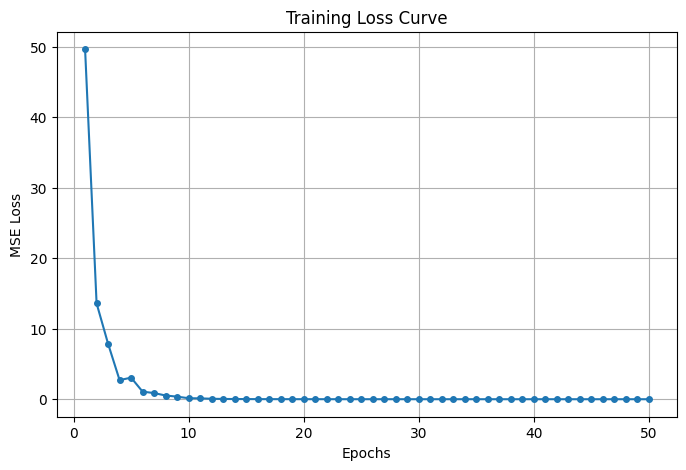

In [43]:

input_dim = 2  # Same as node feature dim
hidden_dim = 32
embedding_dim = 16
model = GraphAutoencoder(input_dim, hidden_dim, embedding_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()  # Reconstruction loss

loss_values = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        outputs = model(batch)
        loss = loss_fn(outputs[batch.train_mask], batch.x[batch.train_mask])  # Compute loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    loss_values.append(total_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

print("Training complete ")

# Plot the loss curve
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_values)+1), loss_values, marker='o', linestyle='-', markersize=4)
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()



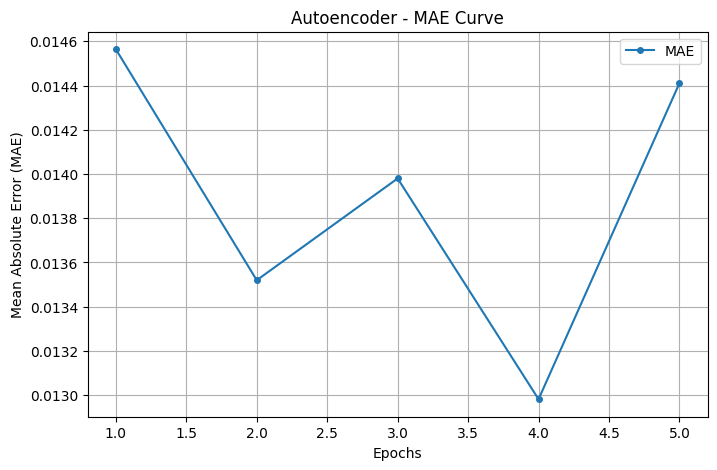

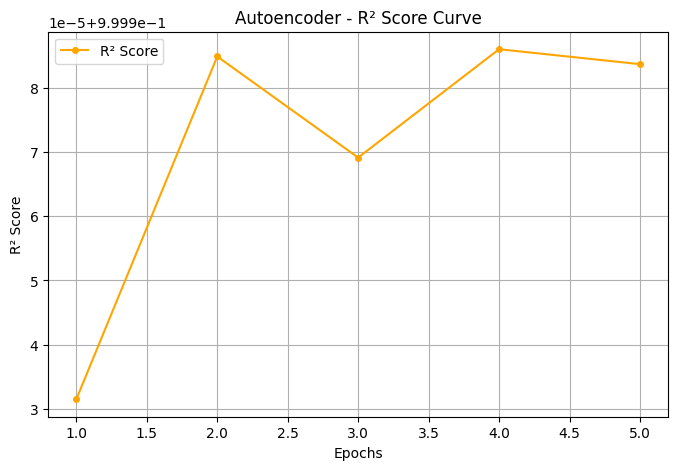

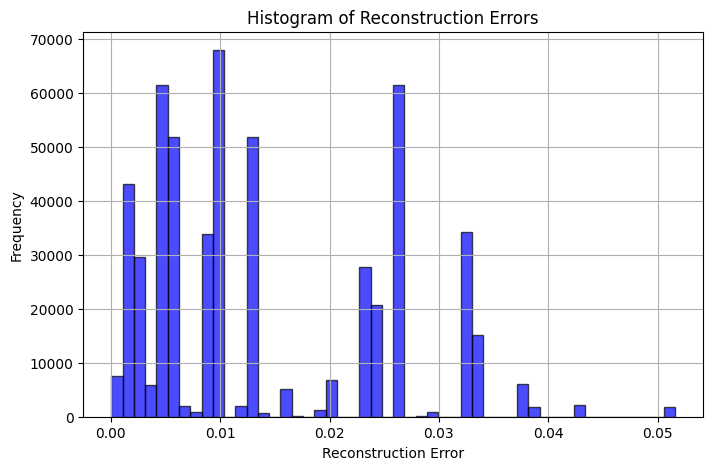

In [44]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

mae_values = []
r2_values = []
reconstruction_errors = []

model.eval()

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        reconstructed = model(batch)  # Reconstructed node features

        errors = (batch.x[batch.test_mask] - reconstructed[batch.test_mask]).cpu().numpy()

        mae = mean_absolute_error(batch.x[batch.test_mask].cpu().numpy(), reconstructed[batch.test_mask].cpu().numpy())
        r2 = r2_score(batch.x[batch.test_mask].cpu().numpy(), reconstructed[batch.test_mask].cpu().numpy())

        mae_values.append(mae)
        r2_values.append(r2)
        reconstruction_errors.extend(np.abs(errors.flatten()))

plt.figure(figsize=(8,5))
plt.plot(range(1, len(mae_values)+1), mae_values, marker='o', linestyle='-', markersize=4, label="MAE")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Autoencoder - MAE Curve")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(r2_values)+1), r2_values, marker='o', linestyle='-', markersize=4, label="R² Score", color='orange')
plt.xlabel("Epochs")
plt.ylabel("R² Score")
plt.title("Autoencoder - R² Score Curve")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Histogram of Reconstruction Errors")
plt.grid(True)
plt.show()
